In [40]:
import logging
import numpy as np
import os
import pandas as pd
import time
import plotly.express as px

from datetime import datetime
from collections import Counter
from itertools import combinations, combinations_with_replacement, permutations

---

In [3]:
df = pd.read_csv('D:/Data/football/results.csv')

In [9]:
'Asian' in list(df['tournament'].unique())

False

In [15]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [29]:
df[df['home_team']=='Jordan']['tournament'].unique()

array(['Arab Cup', 'Friendly', 'AFC Asian Cup qualification',
       'FIFA World Cup qualification', 'Jordan International Tournament',
       'Arab Cup qualification', 'WAFF Championship',
       "Prime Minister's Cup", 'AFC Asian Cup'], dtype=object)

In [34]:
df[df['tournament']=='AFC Asian Cup']

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
4020,1956-09-01,Hong Kong,Israel,2,3,AFC Asian Cup,So Kon Po,Hong Kong,False
4021,1956-09-06,Hong Kong,South Korea,2,2,AFC Asian Cup,So Kon Po,Hong Kong,False
4022,1956-09-08,Israel,South Korea,1,2,AFC Asian Cup,So Kon Po,Hong Kong,True
4023,1956-09-09,Hong Kong,Vietnam Republic,2,2,AFC Asian Cup,So Kon Po,Hong Kong,False
4027,1956-09-12,Israel,Vietnam Republic,2,1,AFC Asian Cup,So Kon Po,Hong Kong,True
...,...,...,...,...,...,...,...,...,...
40950,2019-01-25,South Korea,Qatar,0,1,AFC Asian Cup,Abu Dhabi,United Arab Emirates,True
40951,2019-01-25,United Arab Emirates,Australia,1,0,AFC Asian Cup,Al Ain,United Arab Emirates,False
40953,2019-01-28,Iran,Japan,0,3,AFC Asian Cup,Al Ain,United Arab Emirates,True
40954,2019-01-29,United Arab Emirates,Qatar,0,4,AFC Asian Cup,Abu Dhabi,United Arab Emirates,False


---
위 데이터로 Bradley-Terry Model로 승패 예측이 가능할 것으로 판단됨

#### Plan
1. home_team, away_team 에 현재 16강에 올라간 나라만 리스트업
2. 무경기는 제외, 승패 결과만 뽑아서 데이터 전처리 feature 형태 [team1, team2, team1_win, team2_win]
3. Bradely-Terry Model로 Score 산정
 - https://www.kaggle.com/code/shaz13/code-how-bradley-terry-model-works 참고
4. Score 기반으로 나라별 승률 예측
 - https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=DIKO0013836875&dbt=DIKO 참고
 - 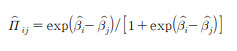

---

#### 예시코드

In [48]:
atrrib_list = ['Excerpt 1', 'Excerpt 2', 'Excerpt 3', 'Excerpt 4', 'Excerpt 5']
pairs = list(permutations(atrrib_list, 2))

In [50]:
pairs = list(combinations(atrrib_list, 2))
print("Following pairs compared wrt readability ")
for i in pairs: print(i[0],'vs',i[1])

Following pairs compared wrt readability 
Excerpt 1 vs Excerpt 2
Excerpt 1 vs Excerpt 3
Excerpt 1 vs Excerpt 4
Excerpt 1 vs Excerpt 5
Excerpt 2 vs Excerpt 3
Excerpt 2 vs Excerpt 4
Excerpt 2 vs Excerpt 5
Excerpt 3 vs Excerpt 4
Excerpt 3 vs Excerpt 5
Excerpt 4 vs Excerpt 5


In [120]:
df = pd.DataFrame(pairs, columns=['Excerpt A','Excerpt B'])
wins_a = [3,11,11,5,19,20,15,8,9,7]
wins_b = [22,14,14,20,6,4,10,9,16,18]
df['Wins A'] = wins_a
df['Wins B'] = wins_b
print("Columns: Excerpt A vs. Exceprt B")
print("Wins A --> Number of times A preferred over B")
print("Wins B ---> Number of times B preferred over A")
df

Columns: Excerpt A vs. Exceprt B
Wins A --> Number of times A preferred over B
Wins B ---> Number of times B preferred over A


,Excerpt A,Excerpt B,Wins A,Wins B
0,Excerpt 1,Excerpt 2,3,22
1,Excerpt 1,Excerpt 3,11,14
2,Excerpt 1,Excerpt 4,11,14
3,Excerpt 1,Excerpt 5,5,20
4,Excerpt 2,Excerpt 3,19,6
5,Excerpt 2,Excerpt 4,20,4
6,Excerpt 2,Excerpt 5,15,10
7,Excerpt 3,Excerpt 4,8,9
8,Excerpt 3,Excerpt 5,9,16
9,Excerpt 4,Excerpt 5,7,18


In [121]:
# 모델 코드
def bradley_terry_analysis(text_data, max_iters=1000, error_tol=1e-3):
    ''' Computes Bradley-Terry using iterative algorithm
        See: https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model
    '''
    # Do some aggregations for convenience
    # Total wins per excerpt
    winsA = text_data.groupby('Excerpt A').agg(sum)['Wins A'].reset_index()
    winsA = winsA[winsA['Wins A'] > 0]
    winsA.columns = ['Excerpt', 'Wins']
    winsB = text_data.groupby('Excerpt B').agg(sum)['Wins B'].reset_index()
    winsB = winsB[winsB['Wins B'] > 0]
    winsB.columns = ['Excerpt', 'Wins']
    wins = pd.concat([winsA, winsB]).groupby('Excerpt').agg(sum)['Wins']

    # Total games played between pairs
    num_games = Counter()
    for index, row in text_data.iterrows():
        key = tuple(sorted([row['Excerpt A'], row['Excerpt B']]))
        total = sum([row['Wins A'], row['Wins B']])
        num_games[key] += total

    # Iteratively update 'ranks' scores
    excerpts = sorted(list(set(text_data['Excerpt A']) | set(text_data['Excerpt B'])))
    ranks = pd.Series(np.ones(len(excerpts)) / len(excerpts), index=excerpts)
    for iters in range(max_iters):
        oldranks = ranks.copy()
        for excerpt in ranks.index:
            denom = np.sum(num_games[tuple(sorted([excerpt, p]))]
                           / (ranks[p] + ranks[excerpt])
                           for p in ranks.index if p != excerpt)
            ranks[excerpt] = 1.0 * wins[excerpt] / denom

        ranks /= sum(ranks)

        if np.sum((ranks - oldranks).abs()) < error_tol:
            break

    if np.sum((ranks - oldranks).abs()) < error_tol:
        logging.info(" * Converged after %d iterations.", iters)
    else:
        logging.info(" * Max iterations reached (%d iters).", max_iters)


    # Note we can control scaling here. For this competiton we have -'ve and positive values on the scale
    # To reproduce the results from example; I choose to multiply the rank with x100
    ranks = ranks.sort_values(ascending=False) \
                    .apply(lambda x : x*100).round(2)

    return ranks

In [122]:
final_scores = pd.DataFrame(bradley_terry_analysis(df), columns=['readability']).reset_index()
final_scores.sort_values(by='index', inplace=True)
final_scores.columns= ['Example Excerpt', 'readability score']
print(">> Target scores")
final_scores

>> Target scores


<ipython-input-121-0c032337b0f0>:29: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



,Example Excerpt,readability score
4,Excerpt 1,7.73
0,Excerpt 2,43.74
2,Excerpt 3,11.71
3,Excerpt 4,10.40
1,Excerpt 5,26.42


In [123]:
ex_r = round(np.exp(11.71-10.40)/(1+np.exp(11.71-10.40)),2)

print('Excerpt 3이 Excerpt4에 대한 승률',ex_r)

ex_t = round(np.exp(10.40-11.71)/(1+np.exp(10.40-11.71)),2)

print('Excerpt 4가 Excerpt3에 대한 승률',ex_t)

Excerpt 3이 Excerpt4에 대한 승률 0.79
Excerpt 4가 Excerpt3에 대한 승률 0.21
